In [85]:
import pandas as pd
pd.options.display.max_columns = 200
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sparklines
from pprint import pprint
import re

# Read second preprocessed

In [86]:
df = pd.read_csv('Data/Digital_Answers.csv', index_col=[0,1])

In [87]:
df.head()

,,Selection,Question,Q_selection_type
subject_nr,option,,,
0,do you have children living in your home (excluding yourself if you are under 18),Yes,do you have children living in your home (excl...,single
1,do you have children living in your home (excluding yourself if you are under 18),Yes,do you have children living in your home (excl...,single
2,do you have children living in your home (excluding yourself if you are under 18),Yes,do you have children living in your home (excl...,single
3,do you have children living in your home (excluding yourself if you are under 18),Yes,do you have children living in your home (excl...,single
4,do you have children living in your home (excluding yourself if you are under 18),Yes,do you have children living in your home (excl...,single


# Binge Watching by Age

In [88]:
# Getting masks
age = df.Question.str.contains('what is your age')
binge_watching = df.Question.str.contains('binge-watch')

# Mergin info and cleaning
binge_fr = df[age].reset_index(level=1)[['Selection']].merge( df[binge_watching].reset_index(level=1)[['Selection']], left_index=True, right_index=True, how='inner', suffixes=['_Age', '_Binge'] )

binge_fr['Selection_Age'] = binge_fr['Selection_Age'].astype(float).astype(int)

binge_fr.head()

,Selection_Age,Selection_Binge
subject_nr,,
0,36,Yes
1,26,No
2,32,Yes
3,25,Yes
4,28,Yes


In [89]:
binge_fr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2131 entries, 0 to 2130
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Selection_Age    2131 non-null   int32 
 1   Selection_Binge  2131 non-null   object
dtypes: int32(1), object(1)
memory usage: 106.2+ KB


In [90]:
# Splitting by decade to reduce granularity
binge_fr['Decade'] = pd.cut(binge_fr['Selection_Age'], bins=[9, 19, 29, 39, 49, 59, 69, 79, 89, 99])#, labels=[18, 20, 30, 40, 50, 60, 70, 80])

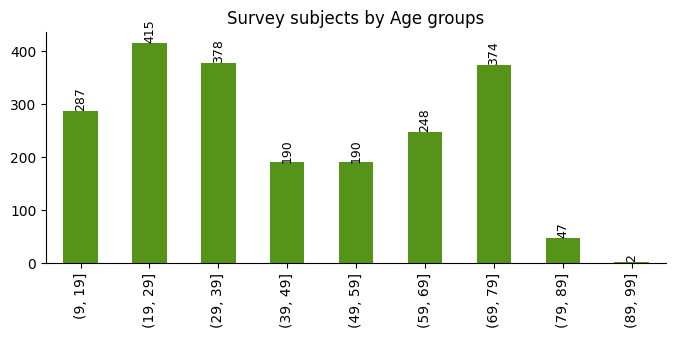

In [91]:
ax = binge_fr['Decade'].value_counts().sort_index().plot(kind='bar', color=['#559419'], figsize=(8,3))
plt.title('Survey subjects by Age groups')
sns.despine(top=True, right=True)

for i in ax.containers:
    ax.bar_label(i, label_type='edge', labels=[f'{int(j.get_height())}' for j in i], fontsize=9, rotation=90)

plt.savefig("PLOTS/AgeGroups.png", dpi=150, bbox_inches="tight", transparent=True)
plt.show()

In [92]:
binge_fr = binge_fr.groupby(by=['Decade','Selection_Binge']).size().reset_index().pivot( index=['Decade'], columns=['Selection_Binge'] ).droplevel(level=0, axis=1)

In [93]:
binge_fr_rel = binge_fr.div(binge_fr.sum(axis=1), axis=0)*100
binge_fr_rel

Selection_Binge,No,Yes
Decade,,
"(9, 19]",13.588850,86.411150
"(19, 29]",13.493976,86.506024
"(29, 39]",16.402116,83.597884
"(39, 49]",26.315789,73.684211
"(49, 59]",31.578947,68.421053
"(59, 69]",54.032258,45.967742
"(69, 79]",59.625668,40.374332
"(79, 89]",74.468085,25.531915
"(89, 99]",100.000000,0.000000


In [94]:
binge_fr_rel.columns.name = 'Do you binge watch?'
binge_fr_rel.index.name = 'Age Groups'
binge_fr_rel = round(binge_fr_rel)

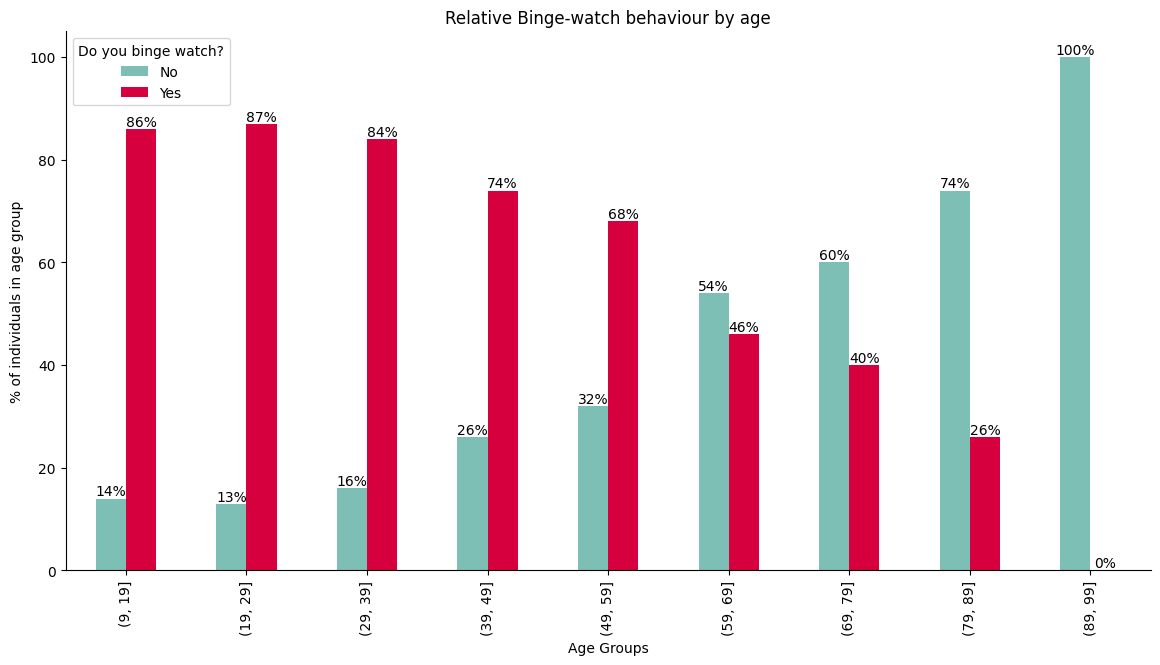

In [95]:
ax = binge_fr_rel.plot(kind='bar', color=['#7dbfb5', '#d7003e'], figsize=(14,7))
plt.title('Relative Binge-watch behaviour by age')
plt.ylabel("% of individuals in age group")
sns.despine(top=True, right=True)

for i in ax.containers:
    ax.bar_label(i, label_type='edge', labels=[f'{int(j.get_height())}%' for j in i])

plt.savefig("PLOTS/Binge-watch behaviour by age.png", dpi=150, bbox_inches="tight", transparent=True)

# Agreement level with sentiment and Age

In [96]:
# Getting masks
agreement = df.Question.str.contains('Agreement')

# Visualizing agreement level options to set readable values in plot
agreement_options = df[agreement].index.get_level_values(level='option').unique().to_list()
agreement_options

['i would rather pay for music online in exchange for not being exposed to advertisements',
 'i would rather pay for tv shows online in exchange for not being exposed to advertisements',
 'i would be willing to provide more personal information online if that meant i could receive advertising more targeted to my needs and interests',
 'i would be willing to view advertising with my streaming video programming if it significantly reduced the cost of the subscription.(e.g., reduced subscription cost by 25%)',
 'by providing more personal information online, i am worried about becoming a victim of identity theft',
 'i would rather pay for sports information online in exchange for not being exposed to advertisements',
 'i would rather pay for games online in exchange for not being exposed to advertisements',
 'i would rather pay for movies online in exchange for not being exposed to advertisements',
 'i would rather pay for news online in exchange for not being exposed to advertisements']

In [97]:
# Making it shorter
agreement_options_short = [
                            'Pay for Music without ads',
                            'Pay for TV shows without ads',
                            'Personal info for targeted ads',
                            'View ads to reduce subscription cost',
                            'Worried about identity theft',
                            'Pay for Sports without ads',
                            'Pay for Games without ads',
                            'Pay for Movies without ads',
                            'Pay for News without ads']

# Creating a dict for replacement
tr_dict = { old_name : new_name for old_name, new_name in zip(agreement_options, agreement_options_short)}

In [98]:
# Getting ages
df_age = df[age].reset_index()[['Selection']].rename(columns={'Selection':'Age'})

df_age['Age'] = df_age['Age'].astype(float).astype(int)

df_age['Age Groups'] = pd.cut(df_age['Age'], bins=[9, 19, 29, 39, 49, 59, 69, 79, 89, 99])

In [99]:
# Filtering
agr_fr = df[agreement].reset_index(level=1)

# Add age
agr_fr = agr_fr.merge(df_age, left_index=True, right_index=True, how='right')

# apply new names
agr_fr['option'] = agr_fr['option'].map(tr_dict)

# Shorter name
agr_fr['Selection'] = agr_fr['Selection'].replace({"N/A; I do not have a basis to answer" : "No basis to answer"})

agr_fr

,option,Selection,Question,Q_selection_type,Age,Age Groups
0,Pay for Music without ads,Agree somewhat,Agreement Level,multiple,36,"(29, 39]"
0,Pay for TV shows without ads,Agree strongly,Agreement Level,multiple,36,"(29, 39]"
0,Personal info for targeted ads,Agree somewhat,Agreement Level,multiple,36,"(29, 39]"
0,View ads to reduce subscription cost,Agree somewhat,Agreement Level,multiple,36,"(29, 39]"
0,Worried about identity theft,Agree strongly,Agreement Level,multiple,36,"(29, 39]"
...,...,...,...,...,...,...
2130,Worried about identity theft,Disagree strongly,Agreement Level,multiple,77,"(69, 79]"
2130,Pay for Sports without ads,Disagree strongly,Agreement Level,multiple,77,"(69, 79]"
2130,Pay for Games without ads,Disagree strongly,Agreement Level,multiple,77,"(69, 79]"
2130,Pay for Movies without ads,Disagree strongly,Agreement Level,multiple,77,"(69, 79]"


In [100]:
# to order plot
selection_cat = pd.api.types.CategoricalDtype(categories=['Agree strongly', 'Agree somewhat', 'Disagree somewhat', 'Disagree strongly', 'No basis to answer'], ordered=True)

option_cat = pd.api.types.CategoricalDtype(categories=[
                            'Pay for Music without ads',
                            'Pay for TV shows without ads',
                            'Pay for Sports without ads',
                            'Pay for Games without ads',
                            'Pay for Movies without ads',
                            'Pay for News without ads',
                            'Personal info for targeted ads',
                            'View ads to reduce subscription cost',
                            'Worried about identity theft'], ordered=True)

# Setting dtype
agr_fr['option'] = agr_fr['option'].astype(option_cat)
agr_fr['Selection'] = agr_fr['Selection'].astype(selection_cat)

In [101]:
agr_fr.head()

,option,Selection,Question,Q_selection_type,Age,Age Groups
0,Pay for Music without ads,Agree somewhat,Agreement Level,multiple,36,"(29, 39]"
0,Pay for TV shows without ads,Agree strongly,Agreement Level,multiple,36,"(29, 39]"
0,Personal info for targeted ads,Agree somewhat,Agreement Level,multiple,36,"(29, 39]"
0,View ads to reduce subscription cost,Agree somewhat,Agreement Level,multiple,36,"(29, 39]"
0,Worried about identity theft,Agree strongly,Agreement Level,multiple,36,"(29, 39]"


In [102]:
agr_fr.isna().sum()

option              0
Selection           0
Question            0
Q_selection_type    0
Age                 0
Age Groups          0
dtype: int64

## Only Agreement level

In [103]:
agr_fr_m = agr_fr.groupby(by=['option', 'Selection']).size().reset_index().pivot(index=['option'], columns=['Selection']).droplevel(0, axis=1)

agr_fr_m

Selection,Agree strongly,Agree somewhat,Disagree somewhat,Disagree strongly,No basis to answer
option,,,,,
Pay for Music without ads,255,435,435,668,338
Pay for TV shows without ads,276,403,346,614,492
Pay for Sports without ads,376,583,411,470,291
Pay for Games without ads,255,518,414,678,266
Pay for Movies without ads,701,770,288,181,191
Pay for News without ads,392,718,303,304,414
Personal info for targeted ads,318,425,343,539,506
View ads to reduce subscription cost,334,509,379,521,388
Worried about identity theft,327,566,417,517,304


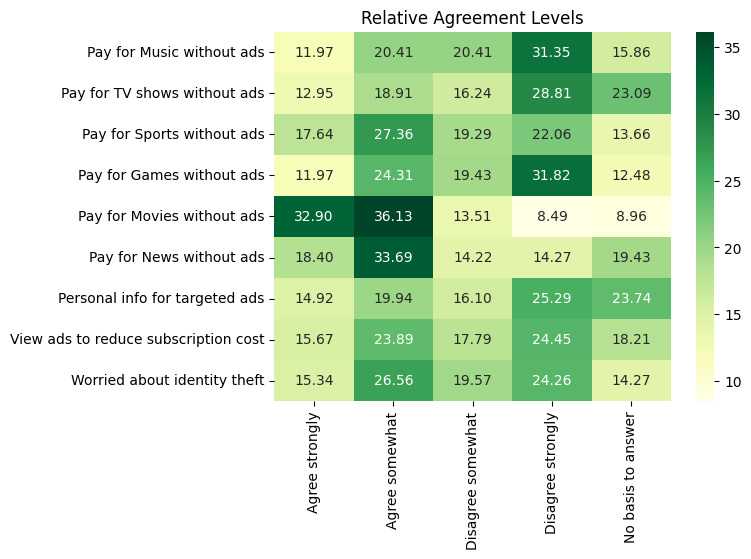

In [104]:
sns.heatmap(agr_fr_m.mul(100/2131), annot=True, cmap="YlGn", fmt='.2f')
plt.ylabel('')
plt.xlabel('')
plt.title('Relative Agreement Levels')

plt.savefig("PLOTS/Relative Agreement Levels.png", dpi=150, bbox_inches="tight", transparent=True)

## Age relative Agreement levels

In [105]:
agr_fr.columns

Index(['option', 'Selection', 'Question', 'Q_selection_type', 'Age',
       'Age Groups'],
      dtype='object')

In [106]:
agr_fr_m2 = agr_fr.groupby(by=['Age Groups','option', 'Selection']).size().reset_index().pivot(index=['option'], columns=['Age Groups', 'Selection']).droplevel(0, axis=1)

agr_fr_m2

Age Groups                                  (9, 19]                 \
Selection                            Agree strongly Agree somewhat   
option                                                               
Pay for Music without ads                        24             68   
Pay for TV shows without ads                     33             59   
Pay for Sports without ads                       59             92   
Pay for Games without ads                        36             95   
Pay for Movies without ads                       85            111   
Pay for News without ads                         70            119   
Personal info for targeted ads                   59             86   
View ads to reduce subscription cost             65             96   
Worried about identity theft                     56             91   

Age Groups                                                                \
Selection                            Disagree somewhat Disagree strongly   
option                                                                     
Pay for Music without ads                           74                70   
Pay for TV shows without ads                        62                68   
Pay for Sports without ads                          62                49   
Pay for Games without ads                           68                61   
Pay for Movies without ads                          37                28   
Pay for News without ads                            41                29   
Personal info for targeted ads                      53                59   
View ads to reduce subscription cost                51                46   
Worried about identity theft                        69                43   

Age Groups                                                    (19, 29]  \
Selection                            No basis to answer Agree strongly   
option                                                                   
Pay for Music without ads                            51             78   
Pay for TV shows without ads                         65             90   
Pay for Sports without ads                           25            102   
Pay for Games without ads                            27             79   
Pay for Movies without ads                           26            130   
Pay for News without ads                             28            112   
Personal info for targeted ads                       30             90   
View ads to reduce subscription cost                 29             97   
Worried about identity theft                         28             96   

Age Groups                                                             \
Selection                            Agree somewhat Disagree somewhat   
option                                                                  
Pay for Music without ads                        99               113   
Pay for TV shows without ads                    115                77   
Pay for Sports without ads                      143                92   
Pay for Games without ads                       136               104   
Pay for Movies without ads                      176                67   
Pay for News without ads                        157                75   
Personal info for targeted ads                  128                83   
View ads to reduce subscription cost            133                89   
Worried about identity theft                    150                77   

Age Groups                                                                 \
Selection                            Disagree strongly No basis to answer   
option                                                                      
Pay for Music without ads                           82                 43   
Pay for TV shows without ads                        68                 65   
Pay for Sports without ads                          50                 28   
Pay for Games with

In [107]:
age_cats = agr_fr_m2.columns.get_level_values(0).unique()

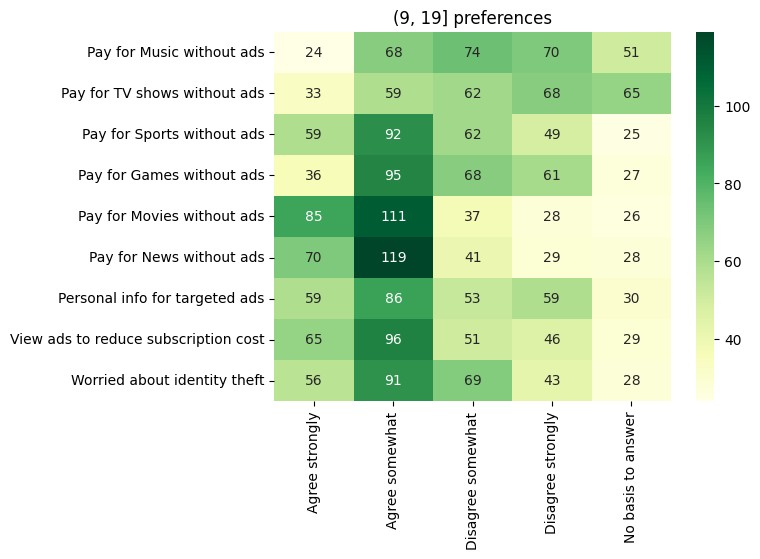

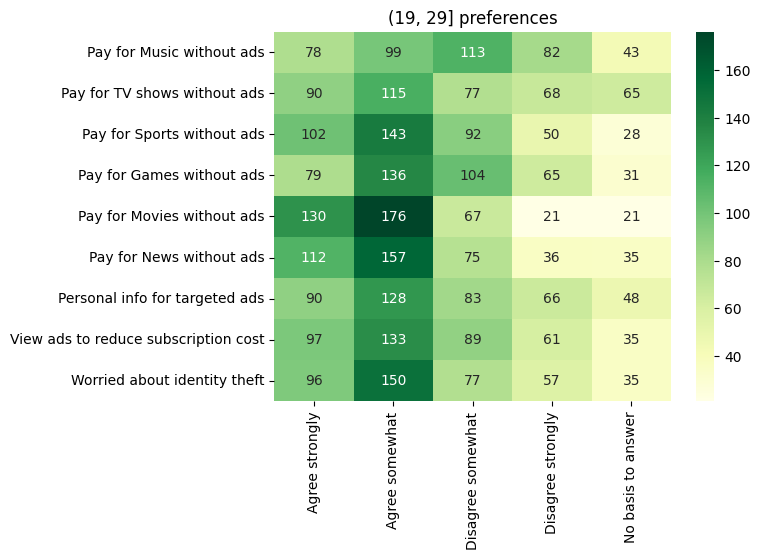

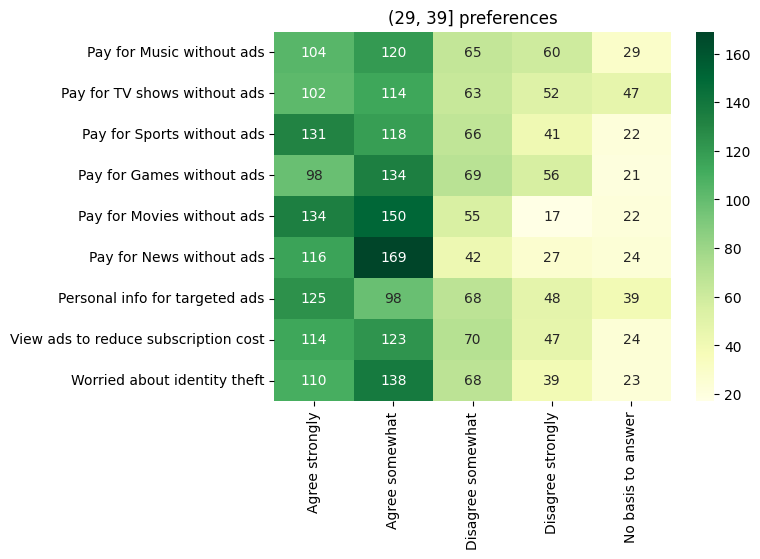

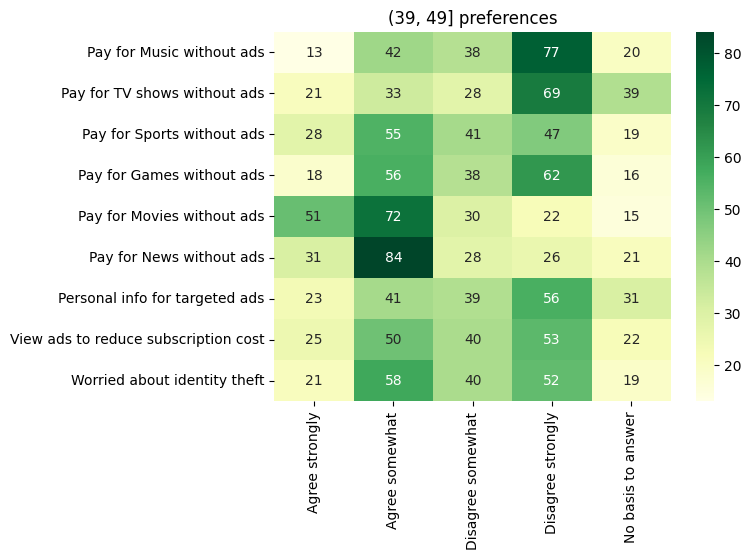

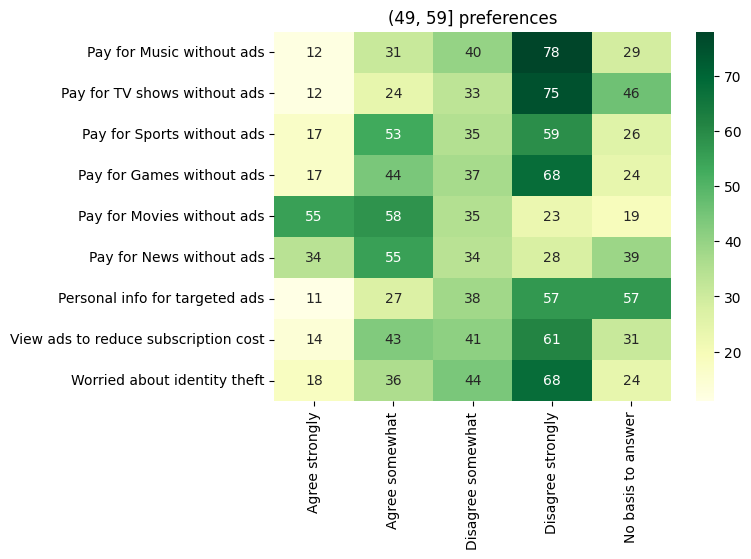

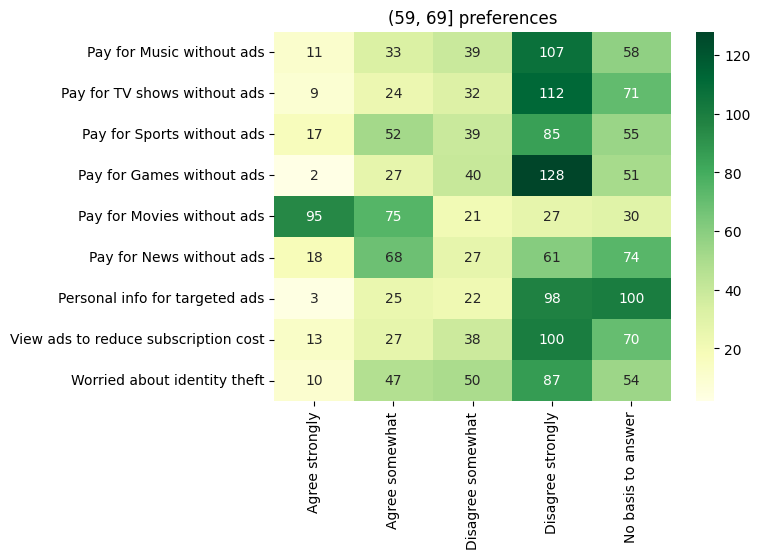

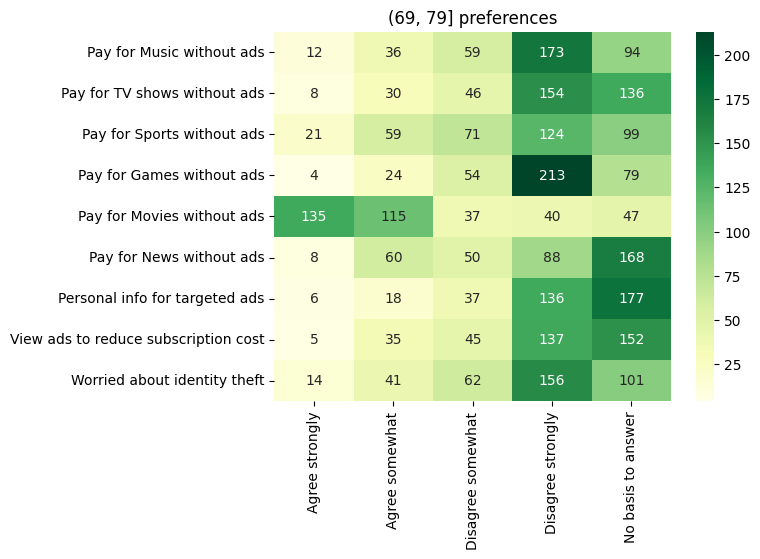

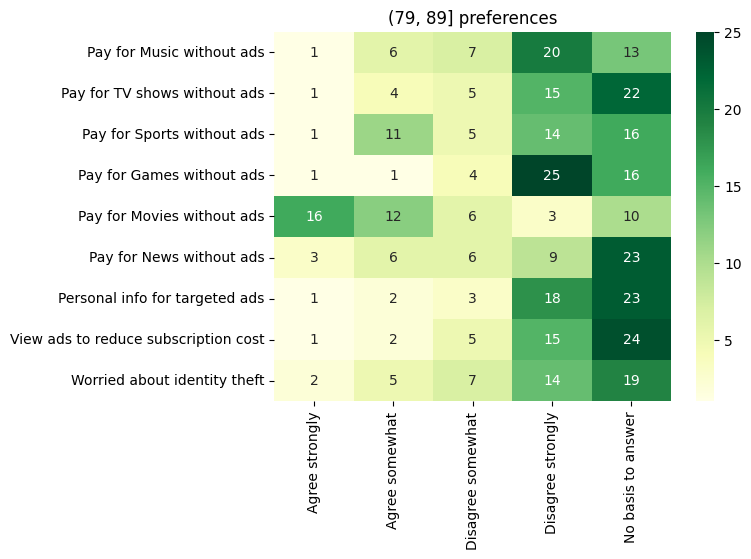

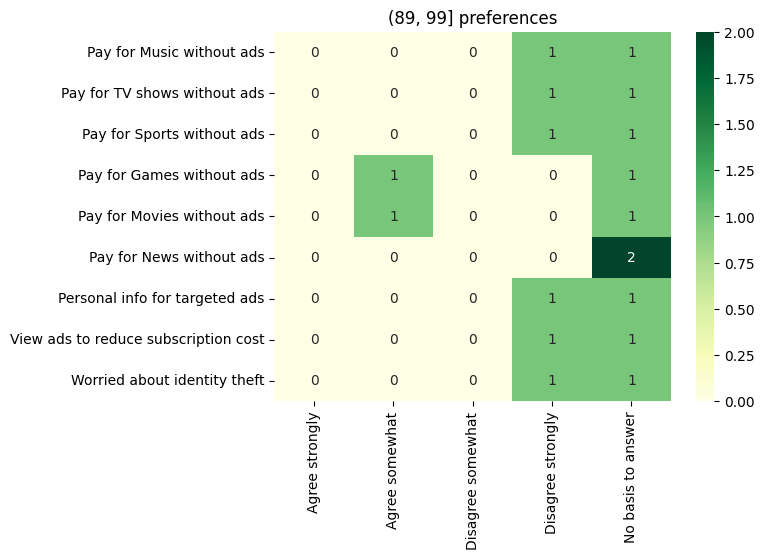

In [108]:
for age_int in age_cats:
    # Frame with the info for that aging category
    c_fr = agr_fr_m2.loc[:,(age_int)]

    sns.heatmap(c_fr, annot=True, cmap="YlGn", fmt="d")
    plt.ylabel('')
    plt.xlabel('')
    plt.title(f'{age_int} preferences')

    plt.savefig(f"PLOTS/{age_int} preferences.png", dpi=150, bbox_inches="tight", transparent=True)
    plt.show()

# % Time spent on devices

In [109]:
dev_time = df.Question.str.contains('of the time you spend watching')

# Filtering info and cleaning
dvt_fr = df[dev_time].reset_index(level=1)#[['Selection']]

print(dvt_fr['Question'].unique())

# Making question names shorter
values_to_check = ['movies', 'sports', 'tv shows']
dvt_fr['Question'] = np.select( [dvt_fr['Question'].str.contains(new_value) for new_value in values_to_check], values_to_check, default='wtf' )

dvt_fr

['of the time you spend watching movies, what percentage of time do you watch on the following devices'
 'of the time you spend watching sports, what percentage of time do you watch on the following devices'
 'of the time you spend watching tv shows , what percentage of time do you watch on the following devices']


,option,Selection,Question,Q_selection_type
subject_nr,,,,
0,tablet,0.0,movies,multiple
0,smartphone,0.0,movies,multiple
0,laptop/desktop,100.0,movies,multiple
0,television,0.0,movies,multiple
1,tablet,40.0,movies,multiple
...,...,...,...,...
2129,smartphone,100.0,tv shows,multiple
2130,laptop/desktop,0.0,tv shows,multiple
2130,television,0.0,tv shows,multiple


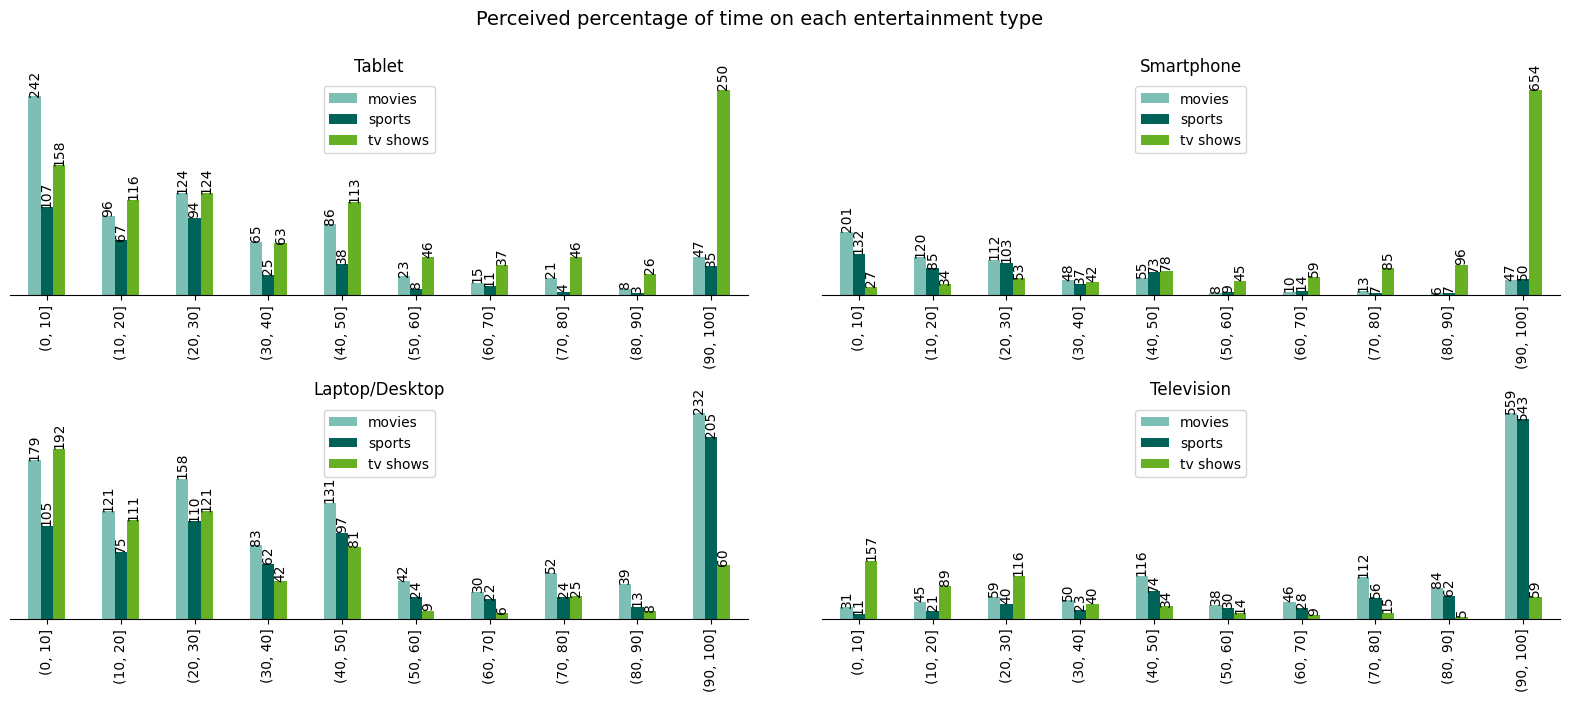

In [121]:
fig, axs = plt.subplots(2, 2, figsize=(20,7), gridspec_kw={'hspace': 0.5, 'wspace':0.1})

for j, _device in enumerate(dvt_fr['option'].unique()):

    # Filtering in option
    fr1 = dvt_fr[dvt_fr['option'] == _device]

    # Getting frame by question
    Qs = {_Q : fr1[(fr1['Question'] == _Q)] for _Q in fr1['Question'].unique()}

    # Getting series with correct dtype and count
    Qs = {_Q : df['Selection'].astype(float).value_counts().sort_index() for _Q, df in Qs.items()}

    # Fixing series name
    for _Q in Qs.keys():
        Qs[_Q].name = _Q

    # Merging and sumarizing
    fr_merged = pd.concat([df for df in Qs.values()], axis=1).sort_index()#.fillna(0)
    # Filtering out 0 for better plot
    fr_merged = fr_merged[fr_merged.index > 0]
    # Grouping bounds
    fr_merged['perc_bins'] = pd.cut(fr_merged.index, bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]) # Percentage bins!!
    fr_merged = fr_merged.groupby(by=['perc_bins']).sum()
    #fr_merged.index.name = 'Percentage Ranges' if j in [2,3] else ''
    fr_merged.index.name = ''
    
    # Determine axis:😢
    if j == 0:
        a,b = 0,0
    elif j == 1:
        a,b = 0,1
    elif j == 2:
        a,b = 1,0
    else:
        a,b = 1,1

    # Plotting each 
    fr_merged.plot(ax=axs[a,b], kind='bar', color=['#7dbfb5', '#006358', '#68b023'])
    # Palette -> https://www.color-hex.com/color-palette/1024050
    #axs[a,b].bar([str(x) for x in fr_merged.index], fr_merged)
    axs[a,b].set_title(f"{_device.title()}")
    axs[a,b].legend(loc='upper center')
    #plt.yscale('log')

    for i in axs[a,b].containers:
        axs[a,b].bar_label(i, label_type='edge', labels=[f'{int(j.get_height())}' for j in i], fontsize=10, rotation=90)

    sns.despine(left=True, top=True, right=True)
    axs[a,b].set_yticks([])

fig.suptitle('Perceived percentage of time on each entertainment type', fontsize=14)
#fig.supxlabel('grouped by percentage groups (0% responses filtered out)', fontsize=8)
plt.show()

fig.savefig('PLOTS/percentage_by_entrType_byDev.png', dpi=250, bbox_inches="tight", transparent=True)

# Doing while watching tv

In [124]:
from pandas.api.types import CategoricalDtype
cat_type = CategoricalDtype(categories=['Always', 'Almost always', 'Frequently', 'Rarely', 'Almost never'], ordered=True)

In [125]:
while_tv = df.Question.str.contains('do while watching your home television system')

# Filtering info and cleaning
wtvfr = df[while_tv].reset_index(level=1)#[['Selection']]

print(wtvfr['Selection'].unique())

# Cleaning Selection
wtvfr['Selection'] = wtvfr['Selection'].str.split("(", expand=True)[0].str.strip()

wtvfr['Selection'] = wtvfr['Selection'].astype(cat_type)

# Mergin age
wtvfr = wtvfr.merge(df_age, left_index=True, right_index=True, how='left')

wtvfr = wtvfr.rename(columns={'option':'activity'})

wtvfr

['Almost always (greater than 75% of the time)'
 'Always (close to 100% of the time)' 'Rarely (10%-50% of the time)'
 'Frequently (between 50% and 75% of the time)' 'Almost never']


,activity,Selection,Question,Q_selection_type,Age,Age Groups
0,read for pleasure,Almost always,which are things you typically do while watchi...,multiple,36,"(29, 39]"
0,write email,Always,which are things you typically do while watchi...,multiple,36,"(29, 39]"
0,talk on the phone,Always,which are things you typically do while watchi...,multiple,36,"(29, 39]"
0,read for work and/or school,Almost always,which are things you typically do while watchi...,multiple,36,"(29, 39]"
0,read email,Almost always,which are things you typically do while watchi...,multiple,36,"(29, 39]"
...,...,...,...,...,...,...
2130,microblogging,Almost never,which are things you typically do while watchi...,multiple,77,"(69, 79]"
2130,browse and surf the web,Rarely,which are things you typically do while watchi...,multiple,77,"(69, 79]"
2130,play video games,Rarely,which are things you typically do while watchi...,multiple,77,"(69, 79]"
2130,use a social network,Almost never,which are things you typically do while watchi...,multiple,77,"(69, 79]"


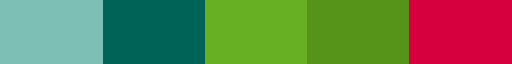

In [29]:
from matplotlib.colors import ListedColormap

personalized_cmap = ListedColormap(['#7dbfb5', '#006358', '#68b023', '#559419', '#d7003e'])

personalized_cmap

In [126]:
tvagrfr = wtvfr\
            .groupby(by=['Age Groups', 'Selection', 'activity'])\
            .size()\
            .reset_index()\
            .pivot(index=['activity','Selection'], columns=['Age Groups'])\
            .droplevel(0, axis=1)

# Adding sparkline trend
tvagrfr['trend'] = tvagrfr.apply(lambda row: sparklines.sparklines(row), axis=1).T
tvagrfr['trend'] = tvagrfr['trend'].apply(lambda x: x[0]) # removing from list

# Styling and saving
fr_plt = tvagrfr.style.background_gradient(cmap='YlGn')

fr_plt

In [127]:
import dataframe_image as dfi
dfi.export(fr_plt, "PLOTS/styled_table.png", table_conversion='selenium')